In [90]:
import os
import os.path as osp
import numpy as np
import math
import pandas as pd
import cv2
import re
from datetime import datetime
from tqdm import tqdm
import shutil
from PIL import Image, ImageOps
def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)
src = "/media/allen/mass/FlowInc_data"
branch = "Office_04"
cam = int(branch.split("_")[-1])
img_list = [osp.join(root, f) for root, _, files in os.walk(osp.join(src, branch)) for f in files if 'jpg' in f]

In [91]:
dst = osp.join(src, f"images_{cam:02}")
if not osp.exists(dst):
    os.mkdir(osp.join(src, f"images_{cam:02}"))

In [52]:
df = pd.read_csv(f"/media/allen/mass/FlowInc_data/{branch}.csv")

In [53]:
df.head()

,file_name,x1_label,y1_label,x2_label,y2_label,occlude_label,tracking_id_label,uniform_label,stand_x,stand_y
0,01_20200405143000.jpg,623.0,654.0,690.0,774.0,0.0,01_0001,0.0,666.0,660.0
1,01_20200405143000.jpg,692.0,486.0,816.0,560.0,0.0,01_0002,0.0,716.0,504.0
2,01_20200405143000.jpg,781.0,540.0,883.0,618.0,0.0,01_0003,1.0,792.0,539.0
3,01_20200405143000.jpg,748.0,370.0,871.0,448.0,0.0,01_0004,1.0,776.0,436.0
4,01_20200405143000.jpg,314.0,272.0,360.0,314.0,0.0,01_0005,0.0,353.0,309.0


In [54]:
df[df.isna().any(axis=1)]

,file_name,x1_label,y1_label,x2_label,y2_label,occlude_label,tracking_id_label,uniform_label,stand_x,stand_y
325,01_20200405143058.jpg,290.0,264.0,343.0,313.0,0.0,01_0024,0.0,NaN,NaN
1040,01_20200405143931.jpg,NaN,NaN,NaN,NaN,NaN,01_0011,NaN,354.0,248.0
1068,01_20200405143936.jpg,NaN,NaN,NaN,NaN,NaN,01_0013,NaN,350.0,601.0


In [55]:
df = df.dropna()

In [56]:
def get_rotate_angle(dx, dy):
    if dy == 0:
        return 0
    angle = np.arctan(np.abs(dx/dy)) / math.pi * 180
    if dx > 0 and dy < 0:
        return angle
    elif dx < 0 and dy < 0:
        return -1 * angle
    elif dx > 0 and dy > 0:
        return 180 - angle
    else:
        return -1 * (180 - angle)

def get_normalized_img(crop, pos):
    pil_img = to_pil(crop)
    crop_w, crop_h = pil_img.size
    x1, y1, x2, y2 = pos
    x, y = (x1+x2) / 2, (y1+y2) / 2
    diag_len = np.sqrt(crop_w**2 + crop_h**2)
    delta_h = diag_len - crop_h
    padding = (0, int(delta_h//2), 0, int(delta_h//2))
    pil_img = ImageOps.expand(pil_img, padding)
    angle = get_rotate_angle(x-cx, y-cy)
    pil_img = pil_img.rotate(angle)
    return pil_img

In [49]:
pattern = re.compile(r'(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})')
f = open(f'../external/{branch}.txt', 'w')
normalized_imgs = []
temp_timestamp = 0
for path in tqdm(sorted(img_list)):
    img = cv2.imread(path)
    h, w = img.shape[:2]
    cx, cy = w * 0.5, h * 0.5
    fname = osp.basename(path)
    labels = df[df['file_name']==fname]
    fname = osp.splitext(fname)[0]
    if len(labels) == 0:
        print(fname)
        continue

    for i in range(len(labels)):
        x1 = int(labels.iloc[i]['x1_label'])
        y1 = int(labels.iloc[i]['y1_label'])
        x2 = int(labels.iloc[i]['x2_label'])
        y2 = int(labels.iloc[i]['y2_label'])
        f.writelines(f"{fname} -1 {x1} {y1} {x2} {y2}\n")
        uniform = int(labels.iloc[i]['uniform_label'])
        occlude = int(labels.iloc[i]['occlude_label'])
        pid = labels.iloc[i]['tracking_id_label'].split("_")[-1]
        color = (0,255,0)
        if uniform:
            color = (0,0,255)
        if occlude == 2:
            color = (0,0,0)
        if x2-x1 != 0 and y2-y1 != 0:
            normalized_img = get_normalized_img(img[y1:y2, x1:x2, :], (x1, y1, x2, y2))
            crop_w, crop_h = normalized_img.size
            if crop_w < 50 and crop_h < 100:
                continue
            if occlude == 2:
                continue
            date_str = fname.split("_")[-1]
            year, month, day, hour, minute, second = map(int, pattern.search(date_str).groups())
            date = datetime(year, month, day, hour, minute, second)
            timestamp = int(datetime.timestamp(date))
            img_name = f"{pid}_c{cam}s1_{uniform}_{timestamp}.jpg"
            # break
            normalized_img.save(osp.join(dst, img_name))
        else:
            print(fname)
    #     cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    # break
f.close()

4_20200401142058
04_20200401142059
04_20200401142100
04_20200401142101

 74%|███████▍  | 1266/1700 [01:34<00:25, 16.94it/s]04_20200401142102
04_20200401142103
04_20200401142104
04_20200401142105

 75%|███████▍  | 1270/1700 [01:34<00:24, 17.41it/s]04_20200401142106
04_20200401142107
04_20200401142108
04_20200401142109

 75%|███████▍  | 1274/1700 [01:34<00:24, 17.20it/s]04_20200401142110
04_20200401142111
04_20200401142112
04_20200401142113

 75%|███████▌  | 1278/1700 [01:34<00:25, 16.49it/s]04_20200401142114
04_20200401142115
04_20200401142116
04_20200401142117

 75%|███████▌  | 1280/1700 [01:35<00:26, 15.83it/s]04_20200401142118
04_20200401142119
04_20200401142120

 76%|███████▌  | 1286/1700 [01:35<00:26, 15.50it/s]04_20200401142121
04_20200401142122
04_20200401142123
04_20200401142124
04_20200401142125

 76%|███████▌  | 1290/1700 [01:35<00:24, 16.49it/s]04_20200401142126
04_20200401142127
04_20200401142128
04_20200401142129

 76%|███████▌  | 1294/1700 [01:35<00:23, 16.98it/s]04_202004

In [92]:
crop_img_list = [osp.join(root, f) for root, _, files in os.walk(dst) for f in files if 'jpg' in f]
clean_dst = osp.join(src, f"images_{cam:02}_1th_clean")
if not osp.exists(clean_dst):
    os.mkdir(osp.join(src, f"images_{cam:02}_1th_clean"))

In [93]:
temp_timestamp = -1
temp_pid = -1
num = 1
for path in tqdm(sorted(crop_img_list)):
    fname = osp.basename(path)
    fname = osp.splitext(fname)[0]
    pid, _, uniform, timestamp = fname.split("_")
    pid = int(pid)
    uniform = int(uniform)
    timestamp = int(timestamp)
    if pid != temp_pid and temp_pid > 0:
        num += 1
    else:
        if np.abs(timestamp - temp_timestamp) > 100 and temp_timestamp > 0:
            num += 1
    temp_pid = pid
    temp_timestamp = timestamp
    img_name = f"{num:04}_c{cam}s1_{uniform}_{timestamp}.jpg"
    shutil.copy(path, osp.join(clean_dst, img_name))


100%|██████████| 1753/1753 [00:01<00:00, 1137.13it/s]

In [96]:
crop_img_list2 = [osp.join(root, f) for root, _, files in os.walk(clean_dst) for f in files if 'jpg' in f]
clean_dst2 = osp.join(src, f"images_{cam:02}_2th_clean")
if not osp.exists(clean_dst2):
    os.mkdir(osp.join(src, f"images_{cam:02}_2th_clean"))

In [97]:
pid_map = {10:3, 18:3, 8:4, 25:5, 11:5, 9:6, 27:13, 22:13, 29:15, 23:15, 24:16, 21:17, 26:7, 20:7}
for path in tqdm(sorted(crop_img_list2)):
    fname = osp.basename(path)
    fname = osp.splitext(fname)[0]
    pid, _, uniform, timestamp = fname.split("_")
    pid = int(pid)
    uniform = int(uniform)
    timestamp = int(timestamp)
    if pid in pid_map:
        pid = pid_map[pid]
    img_name = f"{pid:04}_c{cam}s1_{uniform}_{timestamp}.jpg"
    shutil.copy(path, osp.join(clean_dst2, img_name))


100%|██████████| 1753/1753 [00:00<00:00, 8279.09it/s]

In [112]:
final_dst = osp.join(src, f"bounding_box_train")
if not osp.exists(final_dst):
    os.mkdir(osp.join(src, final_dst))

In [113]:
pids = set()
offset = 0
for cam in [1,2,4]:
    final_src = osp.join(src, f"images_{cam:02}_2th_clean")
    final_img_list = sorted([osp.join(root, f) for root, _, files in os.walk(final_src) for f in files if 'jpg' in f])
    for path in final_img_list:
        fname = osp.basename(path)
        _pid = int(fname[:4])
        pids.add(_pid)
        pid = _pid + offset
        fname = f"{pid:04}" + fname[4:]
        shutil.copy(path, osp.join(final_dst, fname))
    offset += len(pids)

In [44]:

year, month, day, hour, minute, second = map(int, pattern.search(date_str).groups())

In [45]:
year

2020

In [106]:
normalized_imgs = []
for crop, pos in crop_imgs:
    pil_img = to_pil(crop)
    crop_w, crop_h = pil_img.size
    x1, y1, x2, y2 = pos
    x, y = (x1+x2) / 2, (y1+y2) / 2
    diag_len = np.sqrt(crop_w**2 + crop_h**2)
    delta_h = diag_len - crop_h
    padding = (0, int(delta_h//2), 0, int(delta_h//2))
    pil_img = ImageOps.expand(pil_img, padding)
    angle = get_rotate_angle(x-cx, y-cy)
    pil_img = pil_img.rotate(angle)
    normalized_imgs.append(pil_img)

In [94]:
padding

(0, 8.0, 0, 8.0)

In [41]:
pil_img = to_pil(crop_imgs[0][0])

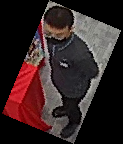

In [104]:
normalized_imgs[3]

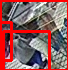

In [78]:
to_pil(crop_imgs[6][0])

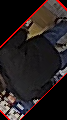

In [45]:
pil_img.rotate(-45)

In [27]:
len(labels)

7